In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

device = torch.device('cpu')


In [2]:
# Define the exact solution
def exact_solution_u(x, t):
    return (2.5*pi*torch.cos(x)+(x-pi*2.5))*torch.cos(t)

def initial_condition_u(x):
    return 2.5*pi*torch.cos(x) + (x - pi*2.5)

def initial_condition_u_t(x):
    return 0.0*pi*torch.cos(x)

# Define the exact solution
def exact_solution_p(x, t):
    return 2.5*pi*torch.sin(x)*torch.cos(t)

def initial_condition_p(x):
    return 2.5*pi*torch.sin(x)

def initial_condition_p_t(x):
    return 0.0*pi*torch.cos(x)

# assigning number of points
initial_pts = 500
left_boundary_pts = 500
right_boundary_pts = 500
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

eps = 5
manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = 3*pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1).to(device)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1).to(device)
w_init = torch.cat([u_init, p_init],1).to(device)

u_t_init = initial_condition_u_t(init[:,0]).reshape(-1, 1).to(device)
p_t_init = initial_condition_p_t(init[:,0]).reshape(-1, 1).to(device)
w_t_init = torch.cat([u_t_init, p_t_init],1).to(device)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = 7*torch.rand((left_boundary_pts, 1)) #
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = exact_solution_u(xb_left, tb_left).to(device)
p_b_l = exact_solution_p(xb_left, tb_left).to(device)
w_b_l = torch.cat([u_b_l, p_b_l],1).to(device)



xb_right = 3*pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = 7*torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = exact_solution_u(xb_right, tb_right).to(device)
p_b_r = exact_solution_p(xb_right, tb_right).to(device)
w_b_r = torch.cat([u_b_r, p_b_r],1).to(device)

# x_interior = pi*torch.rand((residual_pts, 1))
# t_interior = torch.rand((residual_pts, 1))
# interior = torch.cat([x_interior, t_interior],1)

x_int = torch.linspace(0, 3*pi, 102)
x_int = x_int[1:-1]

t_int = torch.linspace(0, 7, 102)
t_int = t_int[1:-1]

x_interior = x_int.tile((100,))
x_interior = x_interior.reshape(-1,1)

t_interior = t_int.repeat_interleave(100)
t_interior = t_interior.reshape(-1,1)

# torch.set_printoptions(threshold=10_000)

interior = torch.cat([x_interior, t_interior],1).to(device)

n = 100  # size of matrix
W = torch.tril(torch.ones(n, n), diagonal=-1).to(device)  # create a lower triangular matrix of ones
W -= torch.diag(torch.diag(W)).to(device)  # set the diagonal elements to zero




training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), w_init.to(device), w_t_init.to(device), b_left.to(device),  b_right.to(device)), batch_size=2000, shuffle=False)


In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [4]:
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = 2, n_hidden_layers=4, neurons=200)
model_state_dict = torch.load('causal_timo.pth', map_location=torch.device('cpu'))
my_network = my_network.to(device)


# after defining my network - also dont forget to comment xavier
my_network.load_state_dict(model_state_dict)

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")


In [5]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, w_initial, w_initial_t, bd_left, bd_right) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:, 0].reshape(-1, 1)
                p_initial_pred_ = w_initial_pred_[:, 1].reshape(-1, 1)

                # with derivative
                inpu = torch.ones(initial_pts, 1).to(device)

                grad_u_ini = \
                torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[
                    0]

                u_initial_t = grad_u_ini[:, 1]

                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]

                p_initial_t = grad_p_ini[:, 1]

                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:, 0].reshape(-1, 1)
                p_bd_left_pred_ = w_bd_left_pred_[:, 1].reshape(-1, 1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:, 0].reshape(-1, 1)
                p_bd_right_pred_ = w_bd_right_pred_[:, 1].reshape(-1, 1)

                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:, 0].reshape(-1, 1)
                p_hat = w_hat[:, 1].reshape(-1, 1)
                inputs = torch.ones(residual_pts, 1).to(device)
                inputs2 = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = \
                torch.autograd.grad(u_hat.reshape(-1, 1), interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0].reshape(-1, 1)

                grad_u_hat_xx = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]

                u_xx = grad_u_hat_xx[:, 0].reshape(-1, 1)

                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                p_x = grad_p_hat[:, 0].reshape(-1, 1)

                grad_p_hat_xx = torch.autograd.grad(p_x, interior, grad_outputs=inputs, create_graph=True)[0]

                p_xx = grad_p_hat_xx[:, 0].reshape(-1, 1)

                # grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                # u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1, 1)

                grad_u_hat_tt = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]

                u_tt = grad_u_hat_tt[:, 1].reshape(-1, 1)

                p_t = grad_p_hat[:, 1].reshape(-1, 1)
                grad_p_hat_tt = torch.autograd.grad(p_t, interior, grad_outputs=inputs, create_graph=True)[0]

                p_tt = grad_p_hat_tt[:, 1].reshape(-1, 1)

                pde_single_column = (u_tt.reshape(-1, ) - u_xx.reshape(-1, ) + u_hat.reshape(-1, ) - p_x.reshape(
                    -1, )) ** 2
                pde_single_column = pde_single_column.reshape(-1, 1)

                pde_matrix = pde_single_column.reshape(100, 100)

                loss_at_time_steps = torch.mean(pde_matrix, 1)
                loss_at_time_steps = loss_at_time_steps.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss = torch.matmul(W, loss_at_time_steps)
                weighted_loss = torch.exp(-eps * weighted_loss)

                loss_pde = torch.mean(weighted_loss * loss_at_time_steps)

                pde_single_column1 = (p_tt.reshape(-1, ) + u_x.reshape(-1, ) - p_xx.reshape(-1, ) + p_hat.reshape(
                    -1, ) - torch.cos(interior[:, 1]).reshape(-1, )) ** 2
                pde_single_column1 = pde_single_column1.reshape(-1, 1)

                pde_matrix1 = pde_single_column1.reshape(100, 100)

                loss_at_time_steps1 = torch.mean(pde_matrix1, 1)
                loss_at_time_steps1 = loss_at_time_steps1.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss1 = torch.matmul(W, loss_at_time_steps1)
                weighted_loss1 = torch.exp(-eps * weighted_loss1)

                loss_pde1 = torch.mean(weighted_loss1 * loss_at_time_steps1)

                # Item 1. below
                loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:, 0].reshape(-1, )) ** p) + torch.mean(
                    (u_initial_pred_.reshape(-1, ) - w_initial[:, 0].reshape(-1, )) ** p) + loss_pde + torch.mean(
                    (u_bd_left_pred_.reshape(-1, ) - u_b_l.reshape(-1, )) ** p) + torch.mean(
                    (u_bd_right_pred_.reshape(-1, ) - u_b_r.reshape(-1, )) ** p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:, 1].reshape(-1, )) ** p) + torch.mean(
                    (p_initial_t.reshape(-1, ) - w_initial_t[:, 1].reshape(-1, )) ** p) + loss_pde1 + torch.mean(
                    (p_bd_left_pred_.reshape(-1, ) - p_b_l.reshape(-1, )) ** p) + torch.mean(
                    (p_bd_right_pred_.reshape(-1, ) - p_b_r.reshape(-1, )) ** p)
                loss = loss1 + loss2
                # loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))

                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [6]:
start_time = time.time()
n_epochs = 3000
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )
end_time = time.time()
total_time = end_time - start_time
print("total_time", total_time)

with open('p10_7.pkl', 'wb') as f:
    pickle.dump(history, f)

f.close()

model_state_dict = my_network.state_dict()

# Save the model state dictionary to a file
torch.save(model_state_dict, 'p10_7.pth')


################################  0  ################################
Loss:  48.433258056640625
################################  1  ################################
Loss:  48.267250061035156
################################  2  ################################
Loss:  43.84218978881836
################################  3  ################################
Loss:  38.51255798339844
################################  4  ################################
Loss:  33.38337707519531
################################  5  ################################
Loss:  29.301605224609375
################################  6  ################################
Loss:  26.15496826171875
################################  7  ################################
Loss:  23.64424705505371
################################  8  ################################
Loss:  21.5607967376709
################################  9  ################################
Loss:  19.9195556640625
################################  10  ###########

Loss:  0.09004846215248108
################################  85  ################################
Loss:  0.08826064318418503
################################  86  ################################
Loss:  0.08650550991296768
################################  87  ################################
Loss:  0.08473358303308487
################################  88  ################################
Loss:  0.08297134190797806
################################  89  ################################
Loss:  0.08111387491226196
################################  90  ################################
Loss:  0.0793580710887909
################################  91  ################################
Loss:  0.07754746079444885
################################  92  ################################
Loss:  0.0756993368268013
################################  93  ################################
Loss:  0.07376238703727722
################################  94  ################################
Loss:  0.0718069970607

Loss:  0.01272712554782629
################################  168  ################################
Loss:  0.012517501600086689
################################  169  ################################
Loss:  0.012329943478107452
################################  170  ################################
Loss:  0.012140613049268723
################################  171  ################################
Loss:  0.011984177865087986
################################  172  ################################
Loss:  0.011839788407087326
################################  173  ################################
Loss:  0.011691033840179443
################################  174  ################################
Loss:  0.011547952890396118
################################  175  ################################
Loss:  0.011419584974646568
################################  176  ################################
Loss:  0.011281074956059456
################################  177  ################################
L

Loss:  0.00732384854927659
################################  250  ################################
Loss:  0.007297559641301632
################################  251  ################################
Loss:  0.007267789915204048
################################  252  ################################
Loss:  0.007245449814945459
################################  253  ################################
Loss:  0.007222367450594902
################################  254  ################################
Loss:  0.00720361340790987
################################  255  ################################
Loss:  0.007184923626482487
################################  256  ################################
Loss:  0.007166570983827114
################################  257  ################################
Loss:  0.007149517070502043
################################  258  ################################
Loss:  0.007133985869586468
################################  259  ################################
Lo

Loss:  0.00645970506593585
################################  332  ################################
Loss:  0.006462317891418934
################################  333  ################################
Loss:  0.006465756334364414
################################  334  ################################
Loss:  0.006473550572991371
################################  335  ################################
Loss:  0.00648178905248642
################################  336  ################################
Loss:  0.006491951644420624
################################  337  ################################
Loss:  0.0065033393912017345
################################  338  ################################
Loss:  0.006516363471746445
################################  339  ################################
Loss:  0.006529094651341438
################################  340  ################################
Loss:  0.0065476614981889725
################################  341  ################################


Loss:  0.006945633329451084
################################  414  ################################
Loss:  0.006942348089069128
################################  415  ################################
Loss:  0.006939557380974293
################################  416  ################################
Loss:  0.0069296518340706825
################################  417  ################################
Loss:  0.0069235507398843765
################################  418  ################################
Loss:  0.006906941533088684
################################  419  ################################
Loss:  0.006885935552418232
################################  420  ################################
Loss:  0.00686028553172946
################################  421  ################################
Loss:  0.0068334368988871574
################################  422  ################################
Loss:  0.006808158941566944
################################  423  ###############################

Loss:  0.0062959459610283375
################################  496  ################################
Loss:  0.006288005970418453
################################  497  ################################
Loss:  0.006279014516621828
################################  498  ################################
Loss:  0.006270542275160551
################################  499  ################################
Loss:  0.006266959942877293
################################  500  ################################
Loss:  0.006262864451855421
################################  501  ################################
Loss:  0.006263646762818098
################################  502  ################################
Loss:  0.006265264004468918
################################  503  ################################
Loss:  0.006266693584620953
################################  504  ################################
Loss:  0.006276001688092947
################################  505  ################################

Loss:  0.006487770937383175
################################  578  ################################
Loss:  0.006494290195405483
################################  579  ################################
Loss:  0.006500411778688431
################################  580  ################################
Loss:  0.006507984362542629
################################  581  ################################
Loss:  0.006514698266983032
################################  582  ################################
Loss:  0.0065233479253947735
################################  583  ################################
Loss:  0.006530474871397018
################################  584  ################################
Loss:  0.00654228962957859
################################  585  ################################
Loss:  0.006558425724506378
################################  586  ################################
Loss:  0.006569233722984791
################################  587  ################################


Loss:  0.006360911764204502
################################  660  ################################
Loss:  0.006357327103614807
################################  661  ################################
Loss:  0.00635366328060627
################################  662  ################################
Loss:  0.00634516216814518
################################  663  ################################
Loss:  0.0063385143876075745
################################  664  ################################
Loss:  0.0063312118873000145
################################  665  ################################
Loss:  0.006322705186903477
################################  666  ################################
Loss:  0.00631561316549778
################################  667  ################################
Loss:  0.006307727191597223
################################  668  ################################
Loss:  0.006301389075815678
################################  669  ################################
L

Loss:  0.006029085256159306
################################  742  ################################
Loss:  0.006017541512846947
################################  743  ################################
Loss:  0.006000468507409096
################################  744  ################################
Loss:  0.005987713113427162
################################  745  ################################
Loss:  0.005974003113806248
################################  746  ################################
Loss:  0.005967084784060717
################################  747  ################################
Loss:  0.005955733824521303
################################  748  ################################
Loss:  0.005947308614850044
################################  749  ################################
Loss:  0.0059351506642997265
################################  750  ################################
Loss:  0.005933105945587158
################################  751  ################################

Loss:  0.0061905235052108765
################################  824  ################################
Loss:  0.0061967154033482075
################################  825  ################################
Loss:  0.006191441789269447
################################  826  ################################
Loss:  0.006192090921103954
################################  827  ################################
Loss:  0.006192830391228199
################################  828  ################################
Loss:  0.00619182363152504
################################  829  ################################
Loss:  0.006194587796926498
################################  830  ################################
Loss:  0.0061918338760733604
################################  831  ################################
Loss:  0.00619124062359333
################################  832  ################################
Loss:  0.006191558204591274
################################  833  ################################

Loss:  0.00568005908280611
################################  906  ################################
Loss:  0.005663949064910412
################################  907  ################################
Loss:  0.00565143208950758
################################  908  ################################
Loss:  0.005636743735522032
################################  909  ################################
Loss:  0.005624460056424141
################################  910  ################################
Loss:  0.005614824127405882
################################  911  ################################
Loss:  0.005604717880487442
################################  912  ################################
Loss:  0.0055980682373046875
################################  913  ################################
Loss:  0.005591086111962795
################################  914  ################################
Loss:  0.005584963597357273
################################  915  ################################
L

Loss:  0.005552145652472973
################################  988  ################################
Loss:  0.0055558509193360806
################################  989  ################################
Loss:  0.005565850995481014
################################  990  ################################
Loss:  0.005573284812271595
################################  991  ################################
Loss:  0.00558993685990572
################################  992  ################################
Loss:  0.005598964169621468
################################  993  ################################
Loss:  0.00560553465038538
################################  994  ################################
Loss:  0.005619642324745655
################################  995  ################################
Loss:  0.005628645420074463
################################  996  ################################
Loss:  0.005642368923872709
################################  997  ################################
L

Loss:  0.005634225904941559
################################  1070  ################################
Loss:  0.005639624781906605
################################  1071  ################################
Loss:  0.0056452625431120396
################################  1072  ################################
Loss:  0.005652053747326136
################################  1073  ################################
Loss:  0.0056556211784482
################################  1074  ################################
Loss:  0.005660116672515869
################################  1075  ################################
Loss:  0.005665518343448639
################################  1076  ################################
Loss:  0.005674430169165134
################################  1077  ################################
Loss:  0.005678183399140835
################################  1078  ################################
Loss:  0.00568491593003273
################################  1079  #########################

Loss:  0.0058275023475289345
################################  1152  ################################
Loss:  0.00582523737102747
################################  1153  ################################
Loss:  0.005822042003273964
################################  1154  ################################
Loss:  0.005820862017571926
################################  1155  ################################
Loss:  0.0058168694376945496
################################  1156  ################################
Loss:  0.00581349665299058
################################  1157  ################################
Loss:  0.005808789748698473
################################  1158  ################################
Loss:  0.005800854414701462
################################  1159  ################################
Loss:  0.00579465739428997
################################  1160  ################################
Loss:  0.005784700624644756
################################  1161  ########################

Loss:  0.005336301401257515
################################  1234  ################################
Loss:  0.005327706225216389
################################  1235  ################################
Loss:  0.0053210994228720665
################################  1236  ################################
Loss:  0.005316594149917364
################################  1237  ################################
Loss:  0.005312749184668064
################################  1238  ################################
Loss:  0.005313619039952755
################################  1239  ################################
Loss:  0.0053135668858885765
################################  1240  ################################
Loss:  0.005316212773323059
################################  1241  ################################
Loss:  0.005319182761013508
################################  1242  ################################
Loss:  0.005324278958141804
################################  1243  #####################

Loss:  0.005345521494746208
################################  1316  ################################
Loss:  0.005350167863070965
################################  1317  ################################
Loss:  0.005355823319405317
################################  1318  ################################
Loss:  0.005361925810575485
################################  1319  ################################
Loss:  0.005366878118366003
################################  1320  ################################
Loss:  0.005372323095798492
################################  1321  ################################
Loss:  0.005376176908612251
################################  1322  ################################
Loss:  0.005378670524805784
################################  1323  ################################
Loss:  0.005384417250752449
################################  1324  ################################
Loss:  0.005384801886975765
################################  1325  #######################

Loss:  0.005424421280622482
################################  1398  ################################
Loss:  0.005433269310742617
################################  1399  ################################
Loss:  0.005444000940769911
################################  1400  ################################
Loss:  0.005453800782561302
################################  1401  ################################
Loss:  0.005467608571052551
################################  1402  ################################
Loss:  0.0054791634902358055
################################  1403  ################################
Loss:  0.005496616940945387
################################  1404  ################################
Loss:  0.005509205162525177
################################  1405  ################################
Loss:  0.005524644628167152
################################  1406  ################################
Loss:  0.0055384524166584015
################################  1407  #####################

Loss:  0.005706849507987499
################################  1480  ################################
Loss:  0.005709212273359299
################################  1481  ################################
Loss:  0.005715240258723497
################################  1482  ################################
Loss:  0.005722441710531712
################################  1483  ################################
Loss:  0.005728127434849739
################################  1484  ################################
Loss:  0.005734250880777836
################################  1485  ################################
Loss:  0.005739585962146521
################################  1486  ################################
Loss:  0.005744771100580692
################################  1487  ################################
Loss:  0.005747999530285597
################################  1488  ################################
Loss:  0.0057532330974936485
################################  1489  ######################

Loss:  0.0056664422154426575
################################  1562  ################################
Loss:  0.005665205884724855
################################  1563  ################################
Loss:  0.005665126256644726
################################  1564  ################################
Loss:  0.005662267096340656
################################  1565  ################################
Loss:  0.005660543218255043
################################  1566  ################################
Loss:  0.0056577157229185104
################################  1567  ################################
Loss:  0.005653948523104191
################################  1568  ################################
Loss:  0.00565131101757288
################################  1569  ################################
Loss:  0.005646349862217903
################################  1570  ################################
Loss:  0.005641550291329622
################################  1571  ######################

Loss:  0.005541709251701832
################################  1644  ################################
Loss:  0.0055403076112270355
################################  1645  ################################
Loss:  0.005538213066756725
################################  1646  ################################
Loss:  0.005534574389457703
################################  1647  ################################
Loss:  0.005531715229153633
################################  1648  ################################
Loss:  0.005528892390429974
################################  1649  ################################
Loss:  0.0055241514928638935
################################  1650  ################################
Loss:  0.005522329360246658
################################  1651  ################################
Loss:  0.005517102312296629
################################  1652  ################################
Loss:  0.0055146170780062675
################################  1653  ####################

Loss:  0.005730515345931053
################################  1726  ################################
Loss:  0.005742865614593029
################################  1727  ################################
Loss:  0.005749260075390339
################################  1728  ################################
Loss:  0.005754525773227215
################################  1729  ################################
Loss:  0.005760842002928257
################################  1730  ################################
Loss:  0.005765549372881651
################################  1731  ################################
Loss:  0.005774360615760088
################################  1732  ################################
Loss:  0.00577880721539259
################################  1733  ################################
Loss:  0.005782525986433029
################################  1734  ################################
Loss:  0.005787508562207222
################################  1735  ########################

Loss:  0.005752324592322111
################################  1808  ################################
Loss:  0.0057523660361766815
################################  1809  ################################
Loss:  0.005751400254666805
################################  1810  ################################
Loss:  0.005749467294663191
################################  1811  ################################
Loss:  0.005746719427406788
################################  1812  ################################
Loss:  0.00574441347271204
################################  1813  ################################
Loss:  0.005739895161241293
################################  1814  ################################
Loss:  0.005737838335335255
################################  1815  ################################
Loss:  0.005733131431043148
################################  1816  ################################
Loss:  0.005731729790568352
################################  1817  #######################

Loss:  0.005691338796168566
################################  1890  ################################
Loss:  0.005694478750228882
################################  1891  ################################
Loss:  0.005699397996068001
################################  1892  ################################
Loss:  0.005701925605535507
################################  1893  ################################
Loss:  0.005707185715436935
################################  1894  ################################
Loss:  0.005709604360163212
################################  1895  ################################
Loss:  0.005712771322578192
################################  1896  ################################
Loss:  0.005715148523449898
################################  1897  ################################
Loss:  0.005716713145375252
################################  1898  ################################
Loss:  0.005717934109270573
################################  1899  #######################

Loss:  0.0056836241856217384
################################  1972  ################################
Loss:  0.0056932768784463406
################################  1973  ################################
Loss:  0.005701159592717886
################################  1974  ################################
Loss:  0.005704833660274744
################################  1975  ################################
Loss:  0.005706995725631714
################################  1976  ################################
Loss:  0.0057047586888074875
################################  1977  ################################
Loss:  0.005696436855942011
################################  1978  ################################
Loss:  0.005687938537448645
################################  1979  ################################
Loss:  0.005672736559063196
################################  1980  ################################
Loss:  0.005655748303979635
################################  1981  ####################

Loss:  0.005504421889781952
################################  2054  ################################
Loss:  0.00550199206918478
################################  2055  ################################
Loss:  0.005497446283698082
################################  2056  ################################
Loss:  0.005495163612067699
################################  2057  ################################
Loss:  0.005491647403687239
################################  2058  ################################
Loss:  0.005488768219947815
################################  2059  ################################
Loss:  0.005486058071255684
################################  2060  ################################
Loss:  0.005483158864080906
################################  2061  ################################
Loss:  0.005481780506670475
################################  2062  ################################
Loss:  0.005479541607201099
################################  2063  ########################

Loss:  0.00524316867813468
################################  2136  ################################
Loss:  0.005240860395133495
################################  2137  ################################
Loss:  0.0052351756021380424
################################  2138  ################################
Loss:  0.005229640286415815
################################  2139  ################################
Loss:  0.005224402993917465
################################  2140  ################################
Loss:  0.005217384546995163
################################  2141  ################################
Loss:  0.005207146052271128
################################  2142  ################################
Loss:  0.005197958089411259
################################  2143  ################################
Loss:  0.005187181755900383
################################  2144  ################################
Loss:  0.0051798392087221146
################################  2145  ######################

Loss:  0.005181025713682175
################################  2218  ################################
Loss:  0.00518327672034502
################################  2219  ################################
Loss:  0.00518705602735281
################################  2220  ################################
Loss:  0.005192778073251247
################################  2221  ################################
Loss:  0.0051962584257125854
################################  2222  ################################
Loss:  0.00520350644364953
################################  2223  ################################
Loss:  0.00520631019026041
################################  2224  ################################
Loss:  0.0052115423604846
################################  2225  ################################
Loss:  0.005215454380959272
################################  2226  ################################
Loss:  0.0052191875874996185
################################  2227  ###########################

Loss:  0.00532879400998354
################################  2300  ################################
Loss:  0.005338645540177822
################################  2301  ################################
Loss:  0.005345544777810574
################################  2302  ################################
Loss:  0.005352389998733997
################################  2303  ################################
Loss:  0.005359855946153402
################################  2304  ################################
Loss:  0.0053633940406143665
################################  2305  ################################
Loss:  0.0053663416765630245
################################  2306  ################################
Loss:  0.005368323531001806
################################  2307  ################################
Loss:  0.0053681181743741035
################################  2308  ################################
Loss:  0.0053691137582063675
################################  2309  ####################

Loss:  0.005272626876831055
################################  2382  ################################
Loss:  0.005270668771117926
################################  2383  ################################
Loss:  0.005271436646580696
################################  2384  ################################
Loss:  0.005268351174890995
################################  2385  ################################
Loss:  0.005267349537461996
################################  2386  ################################
Loss:  0.005263951141387224
################################  2387  ################################
Loss:  0.005261626560240984
################################  2388  ################################
Loss:  0.005256702192127705
################################  2389  ################################
Loss:  0.005250901915132999
################################  2390  ################################
Loss:  0.005243715830147266
################################  2391  #######################

Loss:  0.005127400625497103
################################  2464  ################################
Loss:  0.0051281144842505455
################################  2465  ################################
Loss:  0.005144359543919563
################################  2466  ################################
Loss:  0.00514263054355979
################################  2467  ################################
Loss:  0.00514076417312026
################################  2468  ################################
Loss:  0.005138990469276905
################################  2469  ################################
Loss:  0.0051383040845394135
################################  2470  ################################
Loss:  0.0051361629739403725
################################  2471  ################################
Loss:  0.005138197913765907
################################  2472  ################################
Loss:  0.005136330612003803
################################  2473  ######################

Loss:  0.005066053941845894
################################  2546  ################################
Loss:  0.0050687226466834545
################################  2547  ################################
Loss:  0.005071098450571299
################################  2548  ################################
Loss:  0.0050733028911054134
################################  2549  ################################
Loss:  0.005075980443507433
################################  2550  ################################
Loss:  0.005079938098788261
################################  2551  ################################
Loss:  0.005081702023744583
################################  2552  ################################
Loss:  0.00508598517626524
################################  2553  ################################
Loss:  0.005086882039904594
################################  2554  ################################
Loss:  0.005090790800750256
################################  2555  ######################

Loss:  0.005113318096846342
################################  2628  ################################
Loss:  0.005116007290780544
################################  2629  ################################
Loss:  0.005114205181598663
################################  2630  ################################
Loss:  0.005114852450788021
################################  2631  ################################
Loss:  0.005113690625876188
################################  2632  ################################
Loss:  0.005112056154757738
################################  2633  ################################
Loss:  0.005109255202114582
################################  2634  ################################
Loss:  0.005106332711875439
################################  2635  ################################
Loss:  0.005101481452584267
################################  2636  ################################
Loss:  0.0050973473116755486
################################  2637  ######################

Loss:  0.005026079714298248
################################  2710  ################################
Loss:  0.005026967730373144
################################  2711  ################################
Loss:  0.005026853643357754
################################  2712  ################################
Loss:  0.005027618259191513
################################  2713  ################################
Loss:  0.0050280895084142685
################################  2714  ################################
Loss:  0.0050286282785236835
################################  2715  ################################
Loss:  0.005029612220823765
################################  2716  ################################
Loss:  0.00502951443195343
################################  2717  ################################
Loss:  0.005031172186136246
################################  2718  ################################
Loss:  0.005030074156820774
################################  2719  ######################

Loss:  0.005128293763846159
################################  2792  ################################
Loss:  0.005123160779476166
################################  2793  ################################
Loss:  0.005124938674271107
################################  2794  ################################
Loss:  0.005120358429849148
################################  2795  ################################
Loss:  0.005115970969200134
################################  2796  ################################
Loss:  0.005109603516757488
################################  2797  ################################
Loss:  0.005104526877403259
################################  2798  ################################
Loss:  0.005100701004266739
################################  2799  ################################
Loss:  0.005096886307001114
################################  2800  ################################
Loss:  0.005091788712888956
################################  2801  #######################

Loss:  0.005117847118526697
################################  2874  ################################
Loss:  0.005122905131429434
################################  2875  ################################
Loss:  0.005126175470650196
################################  2876  ################################
Loss:  0.005129956174641848
################################  2877  ################################
Loss:  0.005135701037943363
################################  2878  ################################
Loss:  0.005142501555383205
################################  2879  ################################
Loss:  0.005149494390934706
################################  2880  ################################
Loss:  0.00515655055642128
################################  2881  ################################
Loss:  0.005164896138012409
################################  2882  ################################
Loss:  0.005173518322408199
################################  2883  ########################

Loss:  0.005250412970781326
################################  2956  ################################
Loss:  0.005250943824648857
################################  2957  ################################
Loss:  0.00524840597063303
################################  2958  ################################
Loss:  0.005247974768280983
################################  2959  ################################
Loss:  0.005244126543402672
################################  2960  ################################
Loss:  0.005242387764155865
################################  2961  ################################
Loss:  0.005241301376372576
################################  2962  ################################
Loss:  0.005237434059381485
################################  2963  ################################
Loss:  0.0052350712940096855
################################  2964  ################################
Loss:  0.005231883842498064
################################  2965  #######################

In [7]:
# ## loading the model

# # Load the history from the pickle file
# with open('p10_7.pkl', 'rb') as f:
#     history = pickle.load(f)

# # # Load the model architecture
# # my_network = your_model_module.YourModelClass()  # Instantiate your model class

# # Load the saved model state dictionary
# model_state_dict = torch.load('p10_7.pth', map_location=torch.device('cpu'))

# # Load the model weights
# my_network.load_state_dict(model_state_dict)


Relative Error Test:  0.8912216871976852 %
Relative Error Test:  0.05554451490752399 %


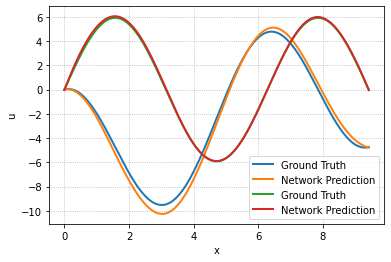

In [8]:
x_test = torch.linspace(0, 3*pi, 10000).reshape(-1,1)
t_test = 7*torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
my_network = my_network.cpu()
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")